# Lab Course: Distributed Data Analytics Exercise Sheet 7
**Submitted by: Mohit Bansal**

**Student ID: 279314**

For this lab you will the network following architecture. You will build a network with the following components (see [6, 7] for more details about components)
1. **conv1**: convolution and rectified linear activation (RELU) 2. pool1: max pooling
3. **conv2**: convolution and rectified linear activation (RELU) 4. pool2: max pooling
5. **FC1**: fully connected layer with rectified linear activation (RELU)
6. **FC2**: fully connected layer with rectified linear activation (RELU)
7. **softmax layer**: final output predictions i.e. classify into one of the ten classes.


## Exercise 1: Normalization Effect (CNN)(7 points)
In the first task you will run some experiments with CIFAR-10 dataset and add normalization layers in the network architecture. The normalization layer should be added after the max pooling layers. Now you should train the CNN model with and without normalization and report the accuracy.
1. Use data augmentation you did in previous lab. (Note: Do not use data augmentation on Test dataset)
2. split your data into Train and Test.
3. Train your model using mini-batch optimization by using tf.train.GradientDescentOptimizer.
4. Report accuracy on Test data.
5. Create a Tensorboard that presents basic information such as scalars, graphs, distributions and histograms. You might check your Tensorboard at localhost:6006.
6. What is the accuracy vs training per epochs for both the cases?
7. What are the performance improvements?

## Exercise 2: Network Regularization (CNN)(7 points)

You have to compare both the solutions with and without dropout regularization.

## Exercise 3: Optimizers (CNN) (6 points)

You will experiment with two different optimizers i.e. tf.train.RMSPropOptimizer and tf.train.AdamOptimizer

### Data Fetching

For data fetching, we will again use unpickle.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


def unpickle(file):
    import pickle
    with open(file,'rb') as fo:
        dict = pickle.load(fo,encoding="bytes")
    return dict

def get_data(file):
    dict = unpickle(file)
    X = np.asarray(dict[b'data']).astype("uint8")
    Yraw = np.asarray(dict[b'labels'])
    Y = np.zeros((10000,10))
    for i in range(10000):
        Y[i,Yraw[i]] = 1
    names = np.asarray(dict[b'filenames'])
    return X,Y,names

### Data Augmentation:

For data augmentation, we will rotate, flip and transpose the image.

In [ ]:
def data_augmentation(x_images,y_labels):
    X_rotate = []    
    tf.reset_default_graph()    
    X = tf.placeholder(tf.float32, shape = (32, 32, 3))    
    k = tf.placeholder(tf.int32)    
    tf_img = tf.image.rot90(X, k = k)    
    with tf.Session() as sess:        
        sess.run(tf.global_variables_initializer())        
        for img in x_images:            
            img_ = np.reshape(img,(32,32,3))
            for i in range(3):  # Rotation at 90, 180 and 270 degrees
                rotated_img = sess.run(tf_img, feed_dict = {X: img_, k: i + 1})
                X_rotate.append(rotated_img)
    X_rotate = np.array(X_rotate, dtype = np.float32)
    
    Y_rotate = []
    
    for i in range(0,len(y_labels)):
        for i in range(3):
            Y_rotate.append(y_labels[i])
    
    X_flip = []
    
    tf.reset_default_graph()
    
    X = tf.placeholder(tf.float32, shape = (32, 32, 3))
    
    tf_img1 = tf.image.flip_left_right(X)
    tf_img2 = tf.image.flip_up_down(X)
    tf_img3 = tf.image.transpose_image(X)
    
    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        
        for img in X_rotate:            
            flipped_imgs = sess.run([tf_img1, tf_img2, tf_img3], feed_dict = {X: img})
            
            X_flip.extend(flipped_imgs)
    X_flip = np.array(X_flip, dtype = np.float32)
    
    y_flip = []
    
    for i in range(0,len(Y_rotate)):
        for i in range(3):
            y_flip.append(Y_rotate[i])    
    y_flip = np.array(y_flip)    
        
    return np.reshape(X_flip,(-1,3072)), y_flip

### Building the neural network

#### Part I: Helper functions

For the convolutional and maxpooling layer, we build 2 helper functions which will be used while making the network.

In [ ]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def maxpool2d(x):
    return tf.nn.max_pool(x, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')

#### Part II: Neural Network

Our function takes 3 inputs:

1. x: Input data
2. use_norm: TRUE or FALSE denoting if normalization layers should be used
3. use_drop: TRUE or FALSE denoting if dropout layers should be used
        
Following architecture was used for the network:

1. **conv1**: convolution and rectified linear activation (RELU) 2. pool1: max pooling
3. **conv2**: convolution and rectified linear activation (RELU) 4. pool2: max pooling
5. **FC1**: fully connected layer with rectified linear activation (RELU)
6. **FC2**: fully connected layer with rectified linear activation (RELU)
7. **softmax layer**: final output predictions i.e. classify into one of the ten classes.


[image.png](attachment:image.png)

In [ ]:
def convolutional_neural_network(x, use_norm, use_drop):       
    weights = {'W_conv1':tf.Variable(tf.random_normal([32,32,3,50])),
               'W_conv2':tf.Variable(tf.random_normal([8,8,50,50])),
               'W_fc1':tf.Variable(tf.random_normal([2*2*50,100])),
               'W_fc2':tf.Variable(tf.random_normal([2*2*25,100])),
               'out':tf.Variable(tf.random_normal([100, 10]))}
    
    biases = {'b_conv1':tf.Variable(tf.random_normal([50])),
              'b_conv2':tf.Variable(tf.random_normal([50])),
               'b_fc1':tf.Variable(tf.random_normal([100])),
               'b_fc2':tf.Variable(tf.random_normal([100])),
               'out':tf.Variable(tf.random_normal([10]))}

    x = tf.reshape(x, shape=[-1,32, 32, 3])   
    # First convolutional and maxpooling layer
    conv1 = tf.nn.relu(conv2d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool2d(conv1)
    
    # Add normailization layers if specified
    if use_norm == True:
        conv1 = tf.contrib.layers.batch_norm(conv1, center=True, scale=True)
    # 2nd convolutional and maxpooling layer    
    conv2 = tf.nn.relu(conv2d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool2d(conv2)

    # Add normailization layers if specified
    if use_norm == True:
        conv2 = tf.contrib.layers.batch_norm(conv2, center=True, scale=True)
    # 1st fully connected layer
    fc1 = tf.reshape(conv2,[ -1,2*2*50])
    fc1 = tf.nn.relu(tf.matmul(fc1, weights['W_fc1'])+biases['b_fc1'])
    
    # Dropout
    if use_drop == True:
        fc1 = tf.layers.dropout(fc1, rate=0.4)    
    # 2nd fully connected layer
    fc2 = tf.reshape(fc1,[ -1,2*2*25])
    fc2 = tf.nn.relu(tf.matmul(fc2, weights['W_fc2'])+biases['b_fc2'])    
    if use_drop == True:
        fc2 = tf.layers.dropout(fc2, rate=0.4)    

    output = tf.matmul(fc2, weights['out'])+biases['out']    
    return output

### Training the neural network

For training the network, we use a batch size of 100. 

Default optimizer is Gradient Descent with a default learning rate of 0.001

We calculate the per epoch error and accuracy.

In [6]:
n_classes = 10
batch_size = 100

def train_neural_network(x, learning_rate = 0.001, use_norm = False, use_drop = False, optimizer = None):
    prediction = convolutional_neural_network(x[0:batch_size], use_norm, use_drop)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels=y) )
    
    # Summarize loss
    tf.summary.scalar("Loss", cost)

    if optimizer == 'Adam':
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost) 
    if optimizer == 'RMSProp':
        optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost) 
    else:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)         
    hm_epochs = 10
    
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        
        liste = [0]
        for epoch in range(hm_epochs):
            epoch_loss = 0
            for _ in range(int(10000/batch_size)):
                index = np.random.choice(len(X),batch_size,replace=False)
                _, c = sess.run([optimizer, cost], feed_dict={x: X[index], y: Y[index]})
#                summ = sess.run(summ, feed_dict={x: X[index], y: Y[index]})
                epoch_loss += c
            print('Epoch', epoch, 'completed out of',hm_epochs,'loss:',epoch_loss)
            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            index = np.random.choice(len(X),batch_size,replace=False)
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
            print('Accuracy:',accuracy.eval({x:Xtest[index], y:Ytest[index]}))
            liste.append(accuracy.eval({x:Xtest[index], y:Ytest[index]}))
        plt.plot(liste)
        plt.ylabel('accuracy')
        plt.show()
        correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        
        # Summarize accuracy
        tf.summary.histogram('Accuracy', accuracy)
        index = np.random.choice(len(X),batch_size,replace=False)
        print('Accuracy:',accuracy.eval({x:Xtest[index], y:Ytest[index]}))
        
        # Merge all summaries and write to a file
        summ = tf.summary.merge_all()
        file_writer = tf.summary.FileWriter('./logs/nn_logs', sess.graph)

### Running the model and calculating statistics

**Disclaimer:** Due to memory and time constraints, I was not able to run the complete tests on my data. 


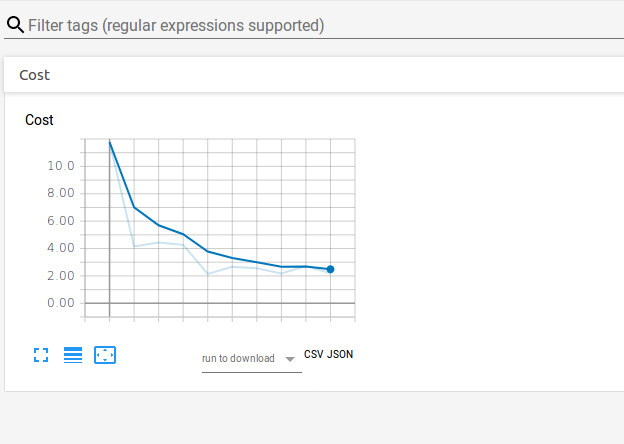
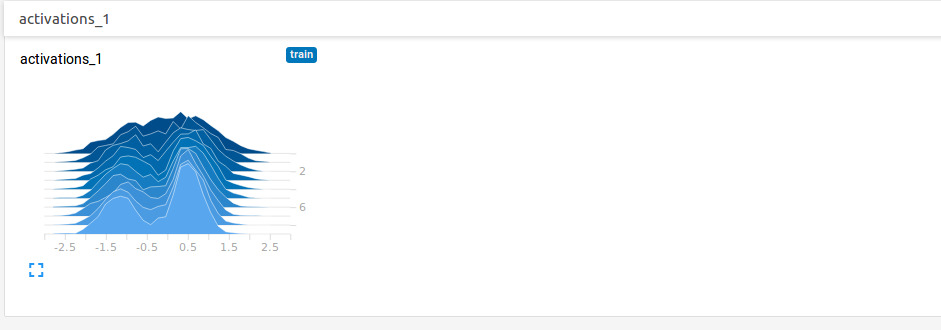
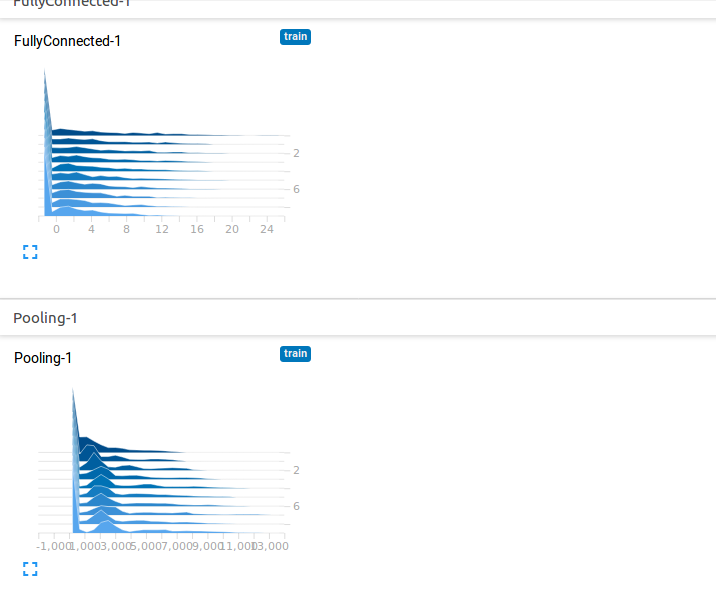
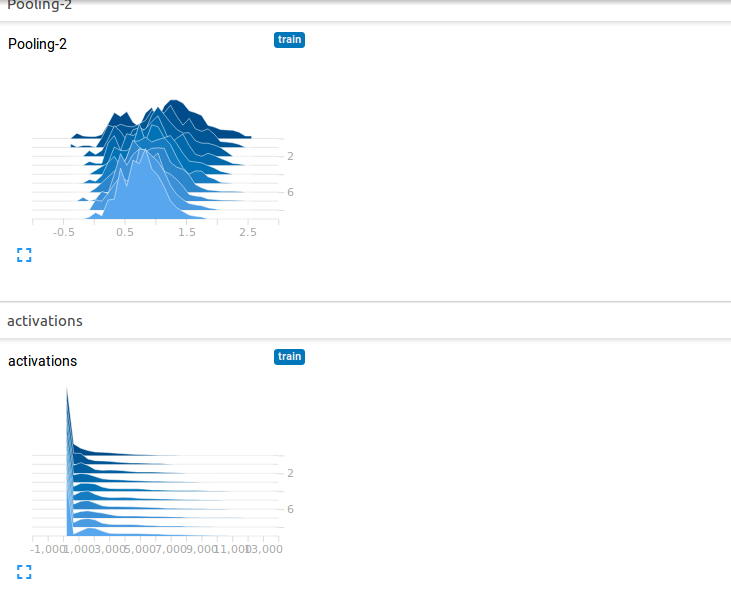
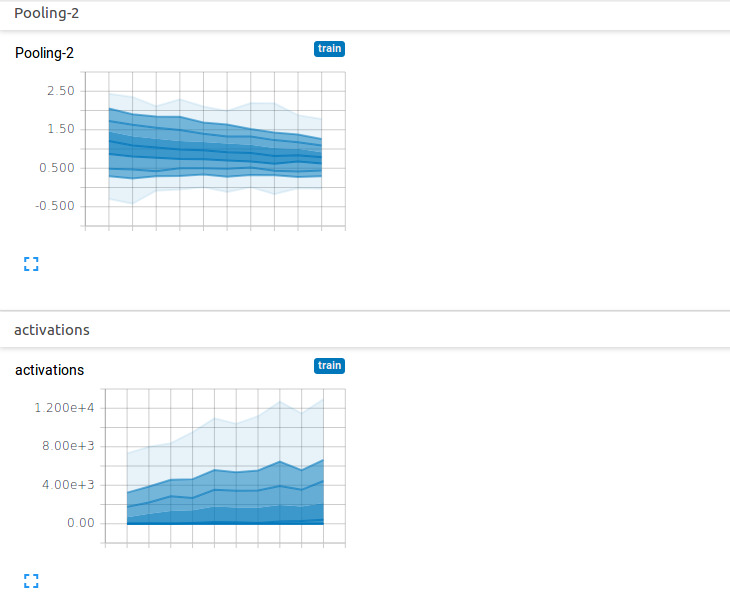


### 1. With & Without Normalization

In [ ]:
X,Y, names = get_data('/Users/mundanemohit/Google Drive/My Work/MSc. Data Analytics/3114 Distributed Data Analytics/Excercises/Ex07/cifar-10-batches-py/data_batch_1')
Xtest,Ytest, namestest = get_data('/Users/mundanemohit/Google Drive/My Work/MSc. Data Analytics/3114 Distributed Data Analytics/Excercises/Ex07/cifar-10-batches-py/test_batch')

x = tf.placeholder('float', [None, 3072])
y = tf.placeholder('float', [None,10])

# Without normalization
print("Without normalization:")
train_neural_network(x, 0.01)

# With normalization
print("With normalization:")
train_neural_network(x, 0.01, use_norm = True)

### Without Normalization

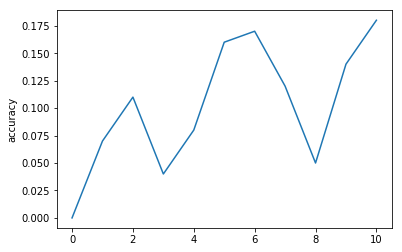


### With Normalization

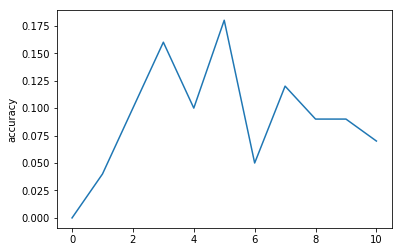

What can be inferred from these two graphs is that, without normalization, the gradient oscillates much more erratically. Adding the normalization function smoothens the gradients thus enabling a better approach towards the minima. 

### 2. Adding dropout regularization


Next, we add 2 dropout layers after every fully-connected layer with a keep probability of 40%. Adding a dropout regularization layer to a fully connected layer serves 2 purposes:

1. **It makes computation faster** - By dropping 60% of nodes at every mini-batch, we do lesser number of calculations thus making the optimization process faster.


2. **It avoids model-overfitting** - Since all the neurons in a layer may not contribute to the output, regularization ensures that we do not accidentally overfit out model

In [ ]:
# With normalization and dropout
print("With normalization & dropout:")
train_neural_network(x, 0.01, use_norm = True, use_drop = True)

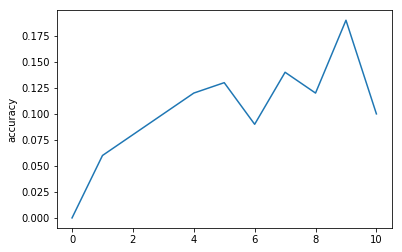

Here, we can see a much better climb to the (possible) local minima. Over an extended training period, this approach would give a better result than one without regularization. This is because regularization makes the network more reliable and robust.

### 3. Other optimizers

Next, we try out other optimizers for the neural network.

Optimizers are the core of any neural network. Optimization technique decides how we plan to minimize loss. The "speed" of travel is decided by a hyper-parameter known as the learning rate. It is a factor multiplied by the gradient at any given step. 

Learning rate is generally static, as in the case of Gradient Descent. However, several advanced optimizers can modify these hyper-parameters on the fly. We are going to compare the following two optimizers with the standard SGD Optimizer:

#### RMSProp 

Root Mean Square Propogation is a modification of the AdaGrad (Adaptive Gradient technique). In **AdaGrad**, we accumulate the historical gradients and adjust the learning rate based on the accumulated gradients. For example, if the gradient is high (steep descent), the learning rate is strongly reduced and vice-versa.

However, since we are accumulating the gradients, it is quite possible that past gradients will affect the current learning rate even if there is a recent drastic change in the topography. 

For example, imagine you are travelling on the Autobahn for hours at 300 Km/h. Suddenly, you see the road going downhill. However, instead of slowing down, you keep going at the same speed since you're now used to it.

**RMSProp** solves this problem by exponentially decaying the effect of older gradients. This is done by giving a high weightage to the latest gradient while accumulating gradients

#### Adam

Adam (Adaptive Moment) is an extension of Stochastic Gradient descent. In addition to adapting the learning rate based on the recent magnitudes of the gradients, it maintains per-parameter learning rates.

In [ ]:
# With normalization, dropout and RMSProp
print("With normalization & dropout & RMSProp:")
train_neural_network(x, 0.01, use_norm = True, use_drop = True, optimizer = 'RMSProp')

# With normalization, dropout and Adam
print("With normalization & dropout & Adam :")
train_neural_network(x, 0.01, use_norm = True, use_drop = True, optimizer = 'Adam')

### RMS Prop

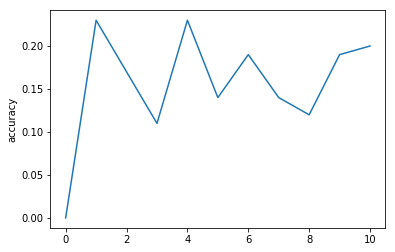

### Adam
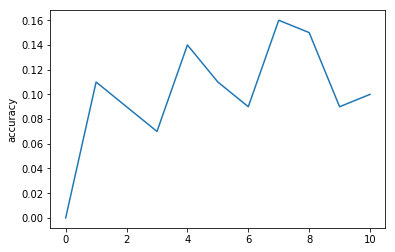

It seems that RMS Prop outperforms Adam in our case.

However, I believe that these results are inconclusive due to the following reasons:

* Due to memory constraints, I had to use a part of the 32x32 image instead of the whole image
* Again, due to memory limitations, we could only use 1 of the 5 training batches
* We are checking results only for 10 epochs. Generally, we would have a better insight if we let the network run for 100 or 1000 epochs

In real world scenarios, Adam & RMSProp have been known to outperform standard SGD. Moreover, regularization & normalization also have positive effects on a network.